# Identify a MHW

In [45]:
import xarray as xr
import json
import gcsfs
import numpy as np
import cmocean
import cartopy.crs as ccrs #cartopy coord ref sys
import cartopy
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import matplotlib.pyplot as plt
import dask

In [2]:
import json
import gcsfs

with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

ds_sst = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/ERA5/datasets/sst_trop_ds.zarr'))

In [5]:
with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    sst = ds_sst.sst.load()

In [6]:
sst

<xarray.DataArray 'sst' (time: 50309, latitude: 109, longitude: 401)>
array([[[26.528534, 26.537628, 26.55774 , ...,       nan,       nan,
               nan],
        [26.541504, 26.543457, 26.555145, ...,       nan,       nan,
               nan],
        [26.55774 , 26.549927, 26.557068, ...,       nan,       nan,
               nan],
        ...,
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]],

       [[26.528534, 26.537628, 26.55774 , ...,       nan,       nan,
               nan],
        [26.541504, 26.543457, 26.555145, ...,       nan,       nan,
               nan],
        [26.55774 , 26.549927, 26.557068, ...,       nan,       nan,
               nan],
...
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]],

       [[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        ...,
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]]], dtype=float32)
Coordinates:
  * latitude   (latitude) float32 8.0 8.25 8.5 8.75 ... 34.25 34.5 34.75 35.0
  * longitude  (longitude) float32 -100.0 -99.75 -99.5 -99.25 ... -0.5 -0.25 0.0
  * time       (time) datetime64[ns] 2018-01-01 ... 2023-09-28T04:00:00

# 99$^{th}$ percentile

In [11]:
q99 = sst.quantile(0.99, dim='time')

In [12]:
q99

<xarray.DataArray 'sst' (latitude: 109, longitude: 401)>
array([[30.15731903, 30.22061768, 30.24614166, ...,         nan,
                nan,         nan],
       [30.22820862, 30.30125397, 30.2943158 , ...,         nan,
                nan,         nan],
       [30.30224091, 30.33683624, 30.32345551, ...,         nan,
                nan,         nan],
       ...,
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan]])
Coordinates:
  * latitude   (latitude) float32 8.0 8.25 8.5 8.75 ... 34.25 34.5 34.75 35.0
  * longitude  (longitude) float32 -100.0 -99.75 -99.5 -99.25 ... -0.5 -0.25 0.0
    quantile   float64 0.99

In [8]:
q99

<xarray.DataArray 'sst' (latitude: 109, longitude: 401)>
dask.array<getitem, shape=(109, 401), dtype=float64, chunksize=(109, 401), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 8.0 8.25 8.5 8.75 ... 34.25 34.5 34.75 35.0
  * longitude  (longitude) float32 -100.0 -99.75 -99.5 -99.25 ... -0.5 -0.25 0.0
    quantile   float64 0.99

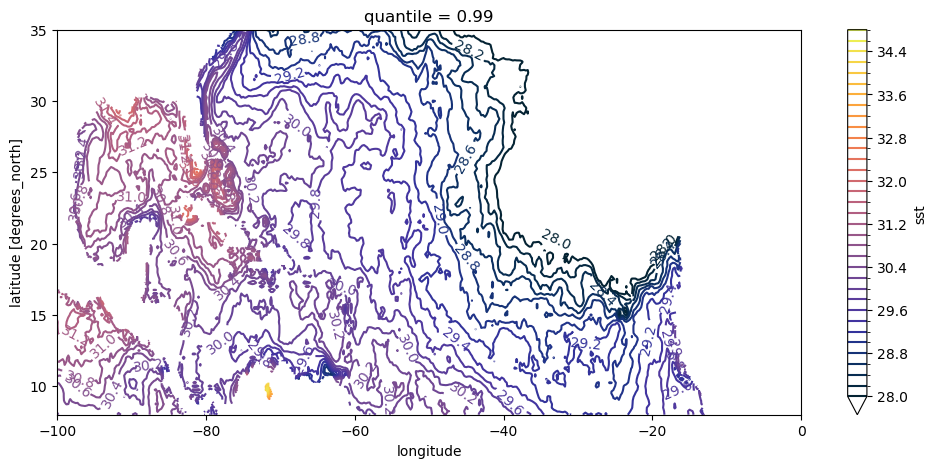

In [19]:
theta_levs = np.arange(28,35,0.2)

fig, ax = plt.subplots(figsize=(12,5))
C = q99.plot.contour(colors=cmocean.cm.thermal, levels=theta_levs, ax=ax, add_colorbar=True)
plt.clabel(C);

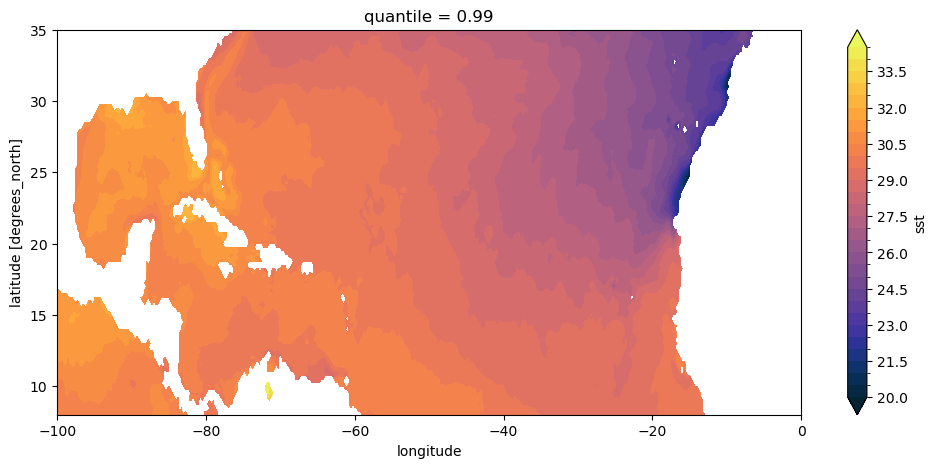

In [18]:
theta_levs = np.arange(20,35,0.5)

fig, ax = plt.subplots(figsize=(12,5))
C = q99.plot.contourf(colors=cmocean.cm.thermal, levels=theta_levs, ax=ax, add_colorbar=True)

In [16]:
q99.max()

<xarray.DataArray 'sst' ()>
array(34.51864624)
Coordinates:
    quantile  float64 0.99

# Find temp above 90$^{th}$ percentile threshold

In [ ]:
#daily clim
#with dask.config.set(**{'array.slicing.split_large_chunks': True}):

clim = sst.groupby('time.dayofyear').mean('time')
clim_std = sst.groupby('time.dayofyear').std('time')
anom = sst.groupby('time.dayofyear') - clim

#monthly clim
mo_clim = sst.groupby('time.month').mean('time')
mo_clim_std = sst.groupby('time.month').std('time')
mo_anom = sst.groupby('time.month') - mo_clim

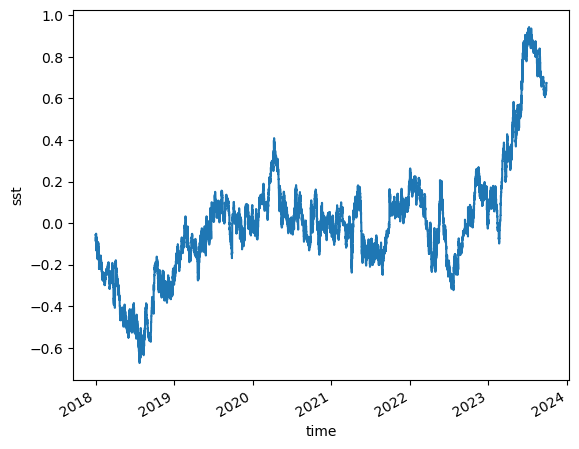

In [29]:
anom.mean(['latitude', 'longitude']).plot()

In [21]:
above_thr = sst.where(sst>=q99, other=np.nan)

In [22]:
above_thr

<xarray.DataArray 'sst' (time: 50309, latitude: 109, longitude: 401)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * latitude   (latitude) float32 8.0 8.25 8.5 8.75 ... 34.25 34.5 34.75 35.0
  * longitude  (longitude) float32 -100.0 -99.75 -99.5 -99.25 ... -0.5 -0.25 0.0
  * time       (time) datetime64[ns] 2018-01-01 ... 2023-09-28T04:00:00
    quantile   float64 0.99

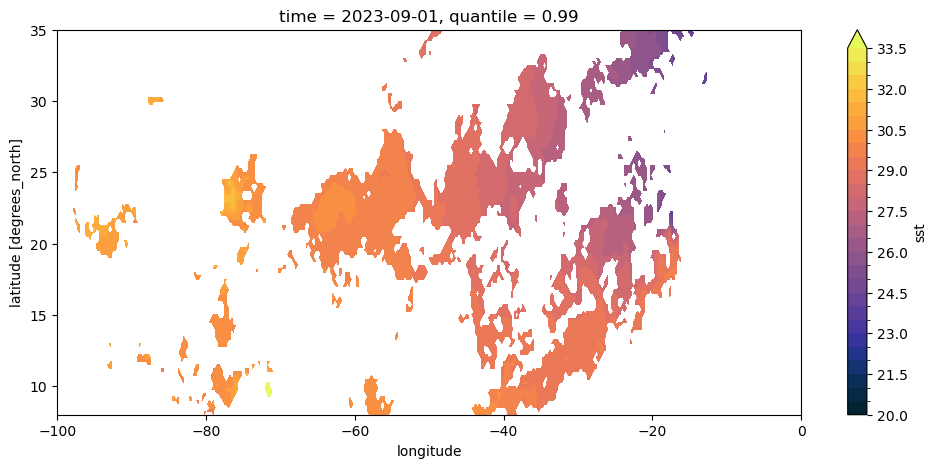

In [25]:
theta_levs = np.arange(20,34,0.5)

fig, ax = plt.subplots(figsize=(12,5))
C = above_thr.sel(time='2023-09-01', method='nearest').plot.contourf(colors=cmocean.cm.thermal, levels=theta_levs, 
                                                                     ax=ax, add_colorbar=True)

/srv/conda/envs/notebook/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/srv/conda/envs/notebook/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


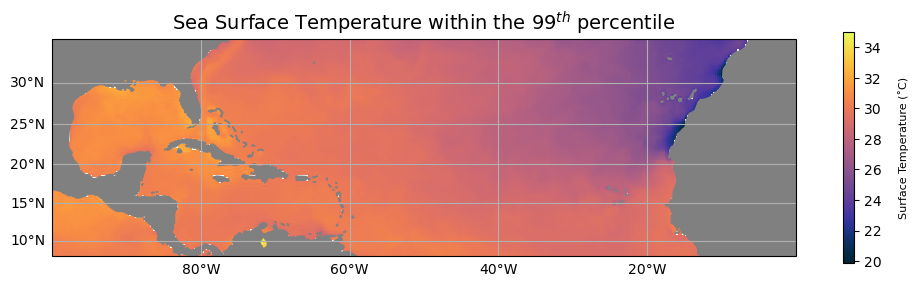

In [57]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(12, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-100, 0, 8, 35], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='0.5'))
#1000m isobath
ax.contour(q99.longitude, q99.latitude, q99, levels=[q99.max()], colors='k', linewidths=2, transform=ccrs.PlateCarree())

im = ax.pcolormesh(q99.longitude, q99.latitude, q99, transform=ccrs.PlateCarree(), cmap=cmocean.cm.thermal, vmax=35)
cb = fig.colorbar(im, ax=ax, shrink=0.2)
cb.set_label("Surface Temperature (˚C)", labelpad=12, fontsize=8)

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

plt.title('Sea Surface Temperature within the 99$^{th}$ percentile', fontsize=14);

/srv/conda/envs/notebook/lib/python3.10/site-packages/flox/aggregations.py:307: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(_var_finalize(sumsq, sum_, count, ddof))


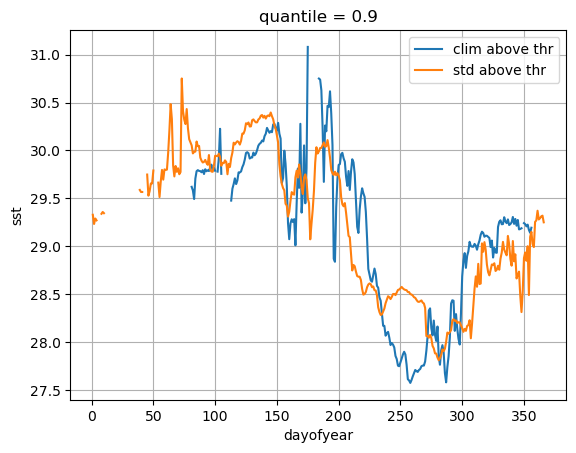

In [49]:
above_thr.mean(['latitude', 'longitude']).plot(label='clim above thr')
above_thr_std.mean(['latitude', 'longitude']).plot(label='std above thr')
plt.legend()
plt.grid();

In [26]:
dty = above_thr.time.groupby('time.year').count()
dt2023 = above_thr.sel(time=slice('2023-01', '2023-09')).time.groupby('time.month').count()

In [30]:
dty

<xarray.DataArray 'time' (year: 6)>
array([8760, 8760, 8784, 8760, 8760, 6485])
Coordinates:
    quantile  float64 0.99
  * year      (year) int64 2018 2019 2020 2021 2022 2023
Attributes:
    long_name:  time

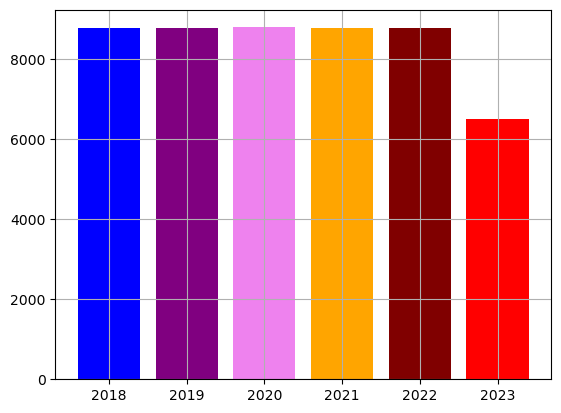

In [35]:
colors = ['blue', 'purple', 'violet', 'orange', 'maroon', 'red']
plt.bar(dty.year, dty, color=colors)
plt.grid()

In [36]:
dt2023

<xarray.DataArray 'time' (month: 9)>
array([744, 672, 744, 720, 744, 720, 744, 744, 653])
Coordinates:
    quantile  float64 0.99
  * month     (month) int64 1 2 3 4 5 6 7 8 9
Attributes:
    long_name:  time

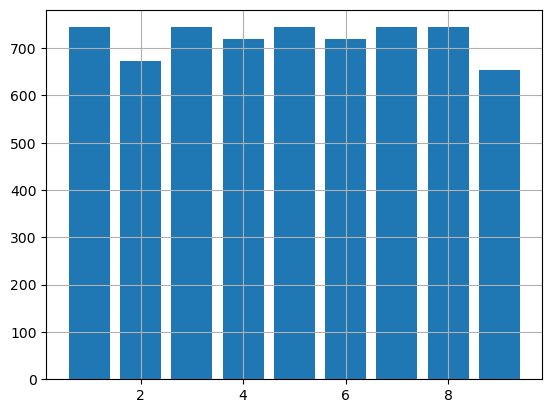

In [38]:
plt.bar(dt2023.month, dt2023)
plt.grid()

# Movie

In [40]:
above_thr.nbytes/1e9

8.795824324

In [43]:
resampled = above_thr.resample(time='D').mean()

In [44]:
resampled

<xarray.DataArray 'sst' (time: 2097, latitude: 109, longitude: 401)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * latitude   (latitude) float32 8.0 8.25 8.5 8.75 ... 34.25 34.5 34.75 35.0
  * longitude  (longitude) float32 -100.0 -99.75 -99.5 -99.25 ... -0.5 -0.25 0.0
    quantile   float64 0.99
  * time       (time) datetime64[ns] 2018-01-01 2018-01-02 ... 2023-09-28

In [58]:
loaded_sst = resampled.compute()

In [59]:
loaded_sst

<xarray.DataArray 'sst' (time: 2097, latitude: 109, longitude: 401)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * latitude   (latitude) float32 8.0 8.25 8.5 8.75 ... 34.25 34.5 34.75 35.0
  * longitude  (longitude) float32 -100.0 -99.75 -99.5 -99.25 ... -0.5 -0.25 0.0
    quantile   float64 0.99
  * time       (time) datetime64[ns] 2018-01-01 2018-01-02 ... 2023-09-28

In [61]:
from xmovie import Movie
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [117]:
import cmocean

def contour_surf(da, fig, tt, *args, **kwargs):
    theta_levs = np.arange(20,35,0.5)
    proj = ccrs.Mercator() #with Mercator you can put lat lon values.
    fig, ax = plt.subplots(subplot_kw=dict(projection=proj))

    ax.set_extent([-100, 0, 8, 35], crs=ccrs.PlateCarree())

    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                            edgecolor='face',
                                            facecolor='0.5'))
    loaded_sst.isel(time=tt).plot.contour(transform=ccrs.PlateCarree(), levels=[q99.max()], colors='black', linewidth=2)
    Cf = da.isel(time=tt).plot.contourf(transform=ccrs.PlateCarree(), colors=cmocean.cm.thermal, levels=theta_levs, 
                                                                ax=ax, add_colorbar=True, cbar_kwargs={'shrink': 0.4},
                                       extend='neither')

    g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
    g1.xlabels_top = False
    g1.ylabels_right = False

    #plt.title(f'{da.time.dt.day.isel(time=tt)}', fontsize=10)

    
    return ax, Cf

(<GeoAxes: title={'center': 'quantile = 0.99, time = 2023-09-24'}, xlabel='longitude', ylabel='latitude [degrees_north]'>,
 <cartopy.mpl.contour.GeoContourSet at 0x7f2c0ceacca0>)

<Figure size 1200x1500 with 0 Axes>

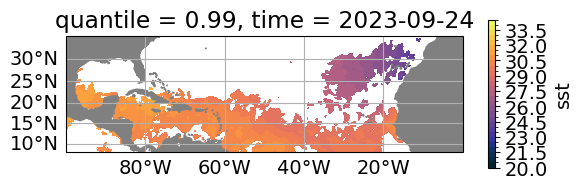

In [118]:
fig = plt.figure(figsize=(12, 15))

contour_surf(loaded_sst, fig, -5)

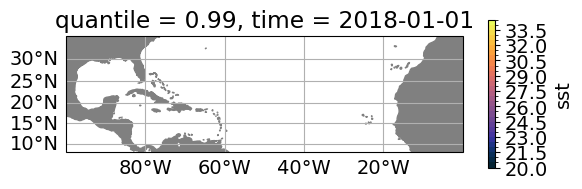

In [119]:
sst = Movie(loaded_sst, contour_surf, 
                   input_check=False)

<Figure size 1920x1080 with 0 Axes>

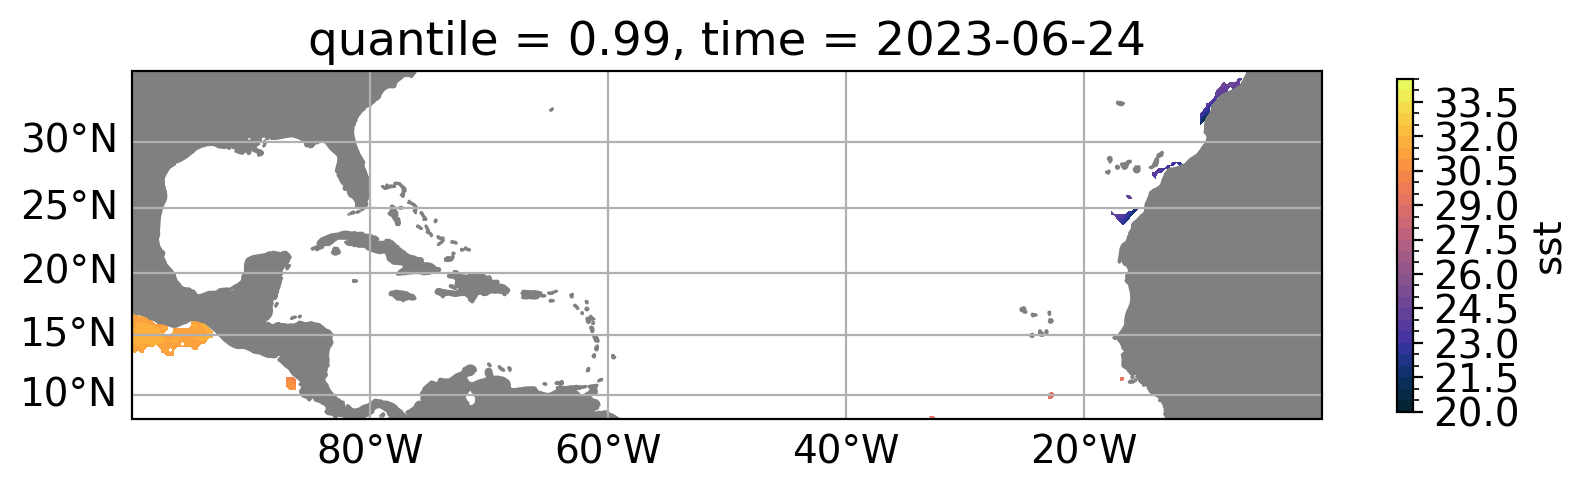

In [122]:
sst.preview(-97)

In [64]:
#save sstmovie
sst.save('sst_above_thr_daily.mp4', progress=True, overwrite_existing=True)

  0%|          | 0/2097 [00:00<?, ?it/s]

Movie created at sst_above_thr_daily.mp4


In [44]:
client.close()
cluster.close()